# <center> Практика. Статистические тесты в контексте EDA

## Постановка задачи

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

Исследовать данные и сделайте выводы по полученным результатам. Подкрепить рассуждения и выводы визуализациями и с помощью статистического тестирования проверить, являются ли выводы статистически значимыми.

В процессе анализа необходимо:
1. Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.
2. А также ответить на **ключевые вопросы HR-агентства**:
    - Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
    - Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
    - Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
    - Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?
3. Отметить другие интересные закономерности в данных.

## <center> 1. Загрузка и обработка данных

In [197]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns

# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set2") 

In [198]:
# загружаем датасет
data = pd.read_csv('data/ds_salaries.csv')
data.head(3)

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M


условия задачи или требования HR агества не установили условия **уровня значимости**, в таком случае по умолчанию принимаем alpha = 0.05

In [199]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


## <center> Анализ данных

In [200]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


В датасете 606 записей (без пропущенных значений).

Проверим данные на наличие полных дубликатов:

In [201]:
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))

# Удаляем дубликаты:
data = data.drop_duplicates()
print('Размер таблицы после удаления дубликатов: {}'.format(data.shape))

Количество дубликатов: 0
Размер таблицы после удаления дубликатов: (607, 12)


## <center> Обработка данных

удалим дублирующие и не нужные признаки (unnamed, salary, salary_currency)

In [202]:
# Удаляем ненужные признаки
data = data.drop(['Unnamed: 0', 'salary', 'salary_currency'], axis=1)
data.head(3) 

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,109024,GB,50,GB,M


следующие признаки переведы в "категориальные":

In [203]:
data['work_year'] = data['work_year'].astype('category')
data['experience_level'] = data['experience_level'].astype('category')
data['employment_type'] = data['employment_type'].astype('category')
data['employee_residence'] = data['employee_residence'].astype('category')
data['remote_ratio'] = data['remote_ratio'].astype('category')
data['company_location'] = data['company_location'].astype('category')
data['company_size'] = data['company_size'].astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   work_year           607 non-null    category
 1   experience_level    607 non-null    category
 2   employment_type     607 non-null    category
 3   job_title           607 non-null    object  
 4   salary_in_usd       607 non-null    int64   
 5   employee_residence  607 non-null    category
 6   remote_ratio        607 non-null    category
 7   company_location    607 non-null    category
 8   company_size        607 non-null    category
dtypes: category(7), int64(1), object(1)
memory usage: 19.5+ KB


Изучим **"job_title"** на количество уникальных позиций

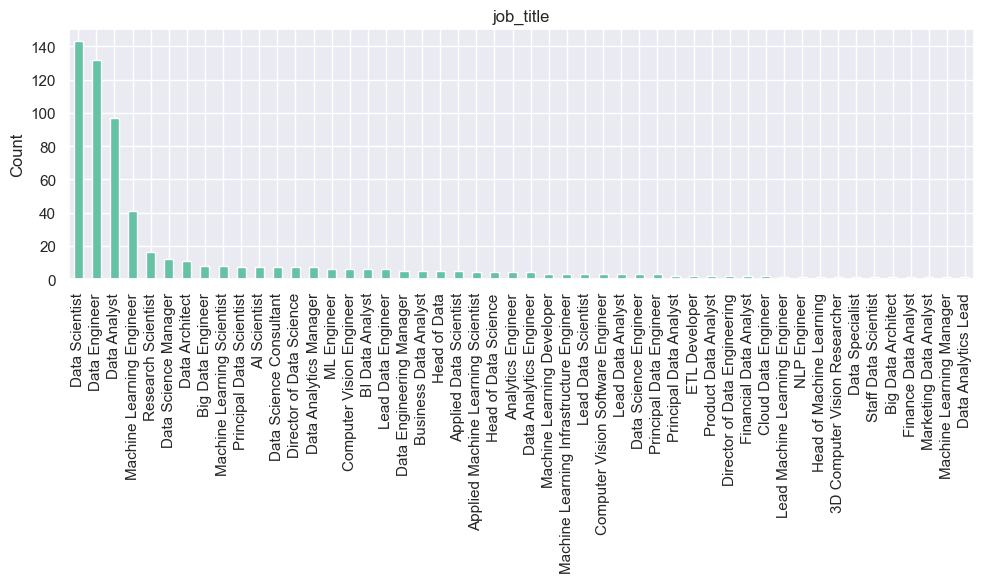

In [204]:
# График распределения для job_title
plt.figure(figsize=(10, 6))
data['job_title'].value_counts().plot(kind='bar')
plt.title('job_title')
plt.xlabel('')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

Нужно отобрать только позиции по Data Scientist & Data Engineer. Дополнительно, необходимо сделать "Разбор текста" всех остальных должностей на предмет причастности к Data Science или Data Engineer

In [205]:
# Новый признак: содержит job_title 'Data Scientist' или 'Data Science'
data['is_data_scientist'] = data['job_title'].str.contains(r'Data Scientist|Data Science', case=False, na=False)
data['is_data_scientist'].value_counts()

is_data_scientist
False    415
True     192
Name: count, dtype: int64

In [206]:
# Новый признак: содержит job_title 'Data Engineer'
data['is_data_engineer'] = data['job_title'].str.contains(r'Data Engineer', case=False, na=False)
data['is_data_engineer'].value_counts()

is_data_engineer
False    449
True     158
Name: count, dtype: int64

Можно уалить признак **'job_title'** из дата сета. Другие направления/специальности нас пока не интересует, анализ ведется только по специальностям **Data Science & Data Engineer** их мы также удаляем. Всего осталось 349 вакансии из изначальных 606 записей.

In [207]:
# Удаляем признак job_title
# data = data.drop(['job_title'], axis=1)

# Удаляем строки, где не Data Scientist и не Data Engineer
data = data[data['is_data_scientist'] | data['is_data_engineer']]
data.reset_index(drop=True, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   work_year           350 non-null    category
 1   experience_level    350 non-null    category
 2   employment_type     350 non-null    category
 3   job_title           350 non-null    object  
 4   salary_in_usd       350 non-null    int64   
 5   employee_residence  350 non-null    category
 6   remote_ratio        350 non-null    category
 7   company_location    350 non-null    category
 8   company_size        350 non-null    category
 9   is_data_scientist   350 non-null    bool    
 10  is_data_engineer    350 non-null    bool    
dtypes: bool(2), category(7), int64(1), object(1)
memory usage: 14.4+ KB


## <center> 2. Разведывательный анализ данных

Взглянем на распределение **"salary_in_usd"** в отдельности по **data_scientist** и по **data_engineer**

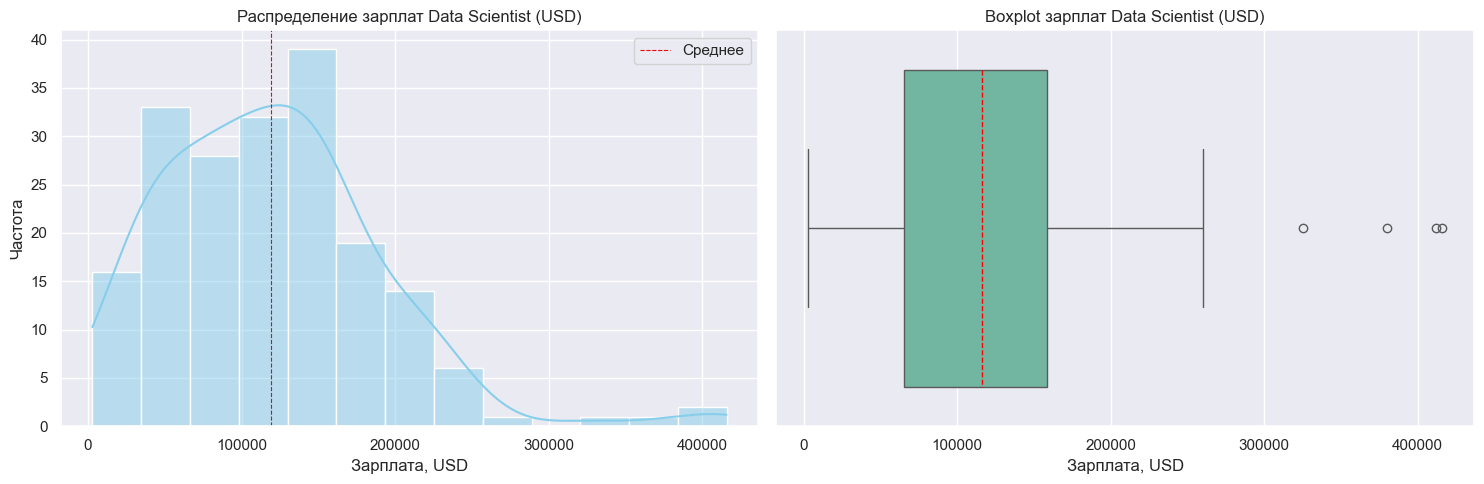

In [208]:
# Гистограмма и boxplot зарплат (USD) для Data Scientist
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data[data['is_data_scientist']]['salary_in_usd'], kde=True, ax=axes[0], color='skyblue')
axes[0].set(xlabel='Зарплата, USD', ylabel='Частота')
axes[0].set_title('Распределение зарплат Data Scientist (USD)')
axes[0].axvline(data[data['is_data_scientist']]['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8, label='Среднее')
axes[0].legend()
sns.boxplot(x=data[data['is_data_scientist']]['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(xlabel='Зарплата, USD')
axes[1].set_title('Boxplot зарплат Data Scientist (USD)')
plt.tight_layout()
plt.show()

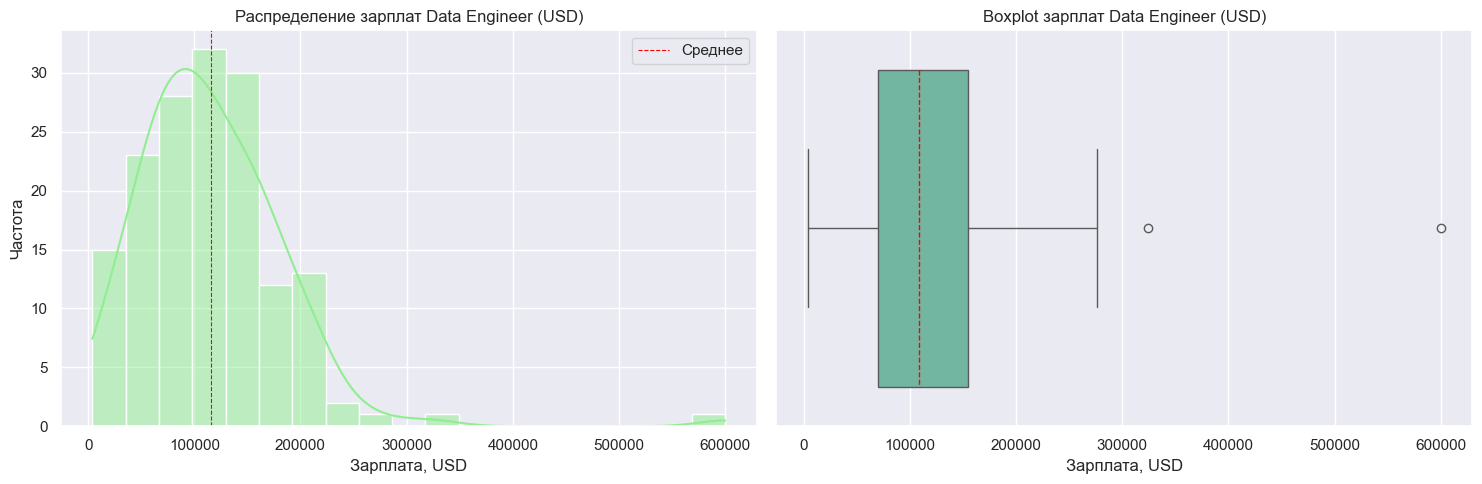

In [209]:
# Гистограмма и boxplot зарплат (USD) для Data Engineer
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data[data['is_data_engineer']]['salary_in_usd'], kde=True, ax=axes[0], color='lightgreen')
axes[0].set(xlabel='Зарплата, USD', ylabel='Частота')
axes[0].set_title('Распределение зарплат Data Engineer (USD)')
axes[0].axvline(data[data['is_data_engineer']]['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8, label='Среднее')
axes[0].legend()
sns.boxplot(x=data[data['is_data_engineer']]['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(xlabel='Зарплата, USD')
axes[1].set_title('Boxplot зарплат Data Engineer (USD)')
plt.tight_layout()
plt.show()

In [210]:
data_agg = data.groupby('is_data_scientist')['salary_in_usd'].describe().round(2)
print('Заработные платы в зависимости от должности')
data_agg

Заработные платы в зависимости от должности


,count,mean,std,min,25%,50%,75%,max
is_data_scientist,,,,,,,,
False,158.0,115808.51,70474.68,4000.0,69805.75,108912.0,154900.0,600000.0
True,192.0,119125.48,71408.23,2859.0,65036.25,115957.0,158400.0,416000.0


На первый взгляд заработные платы для Data Scientist и Data Engineer вполне сопоставимы (минимальные различия), но количество вакансий все же больше по специальности Data Scientist

Проверим потенциальные выбросы с заработной платой свыше 300тыс долларов, на предмет действительности. (предварительно, это вакансии для специалистов высокой квалификации "Principal/Director", удалят их не станем)

In [211]:
high_salary = data[data['salary_in_usd'] > 300000]
high_salary

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,is_data_scientist,is_data_engineer
14,2020,EX,FT,Director of Data Science,325000,US,100,US,L,True,False
38,2020,SE,FT,Data Scientist,412000,US,100,US,L,True,False
127,2021,EX,CT,Principal Data Scientist,416000,US,100,US,S,True,False
146,2021,EX,FT,Principal Data Engineer,600000,US,100,US,L,False,True
284,2022,EX,FT,Data Engineer,324000,US,100,US,M,False,True
304,2022,SE,FT,Applied Data Scientist,380000,US,100,US,L,True,False


Далее изучим категориальные признаки по обоим группам и сравним их

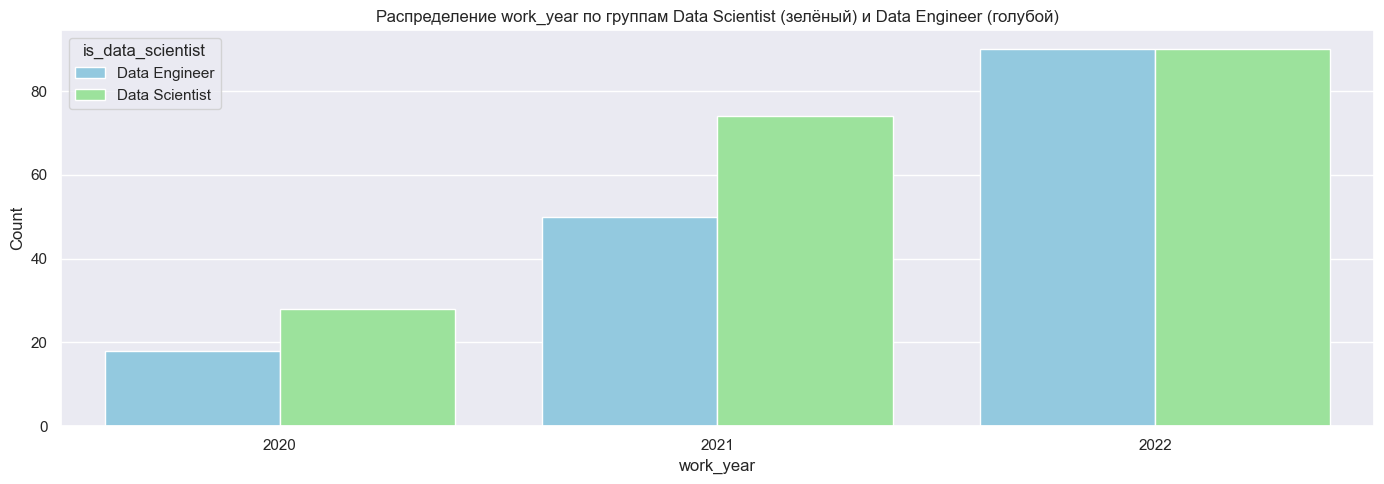

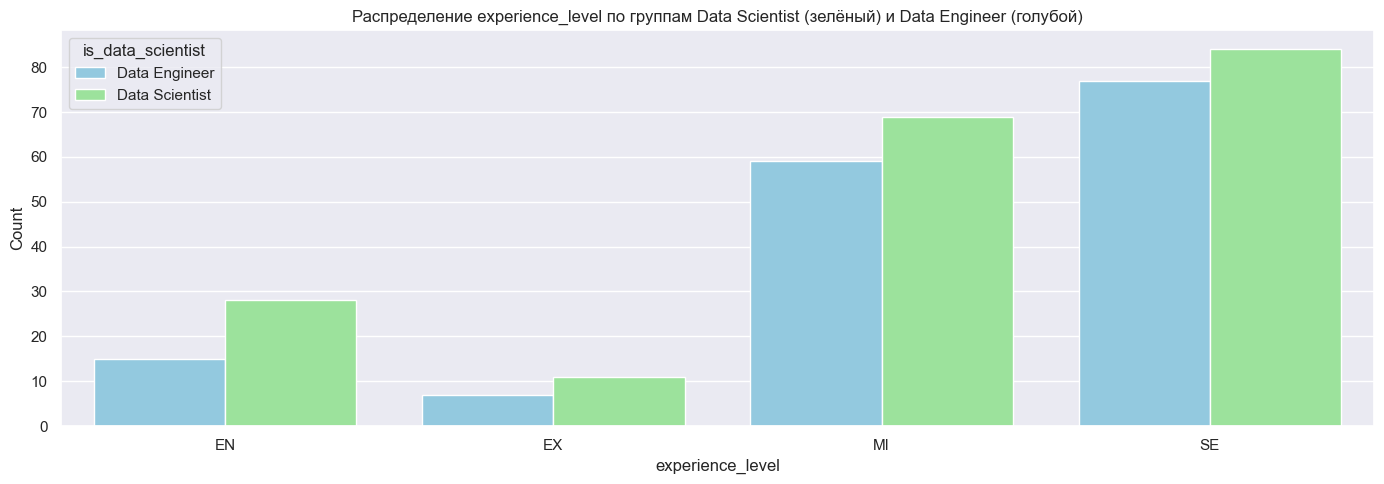

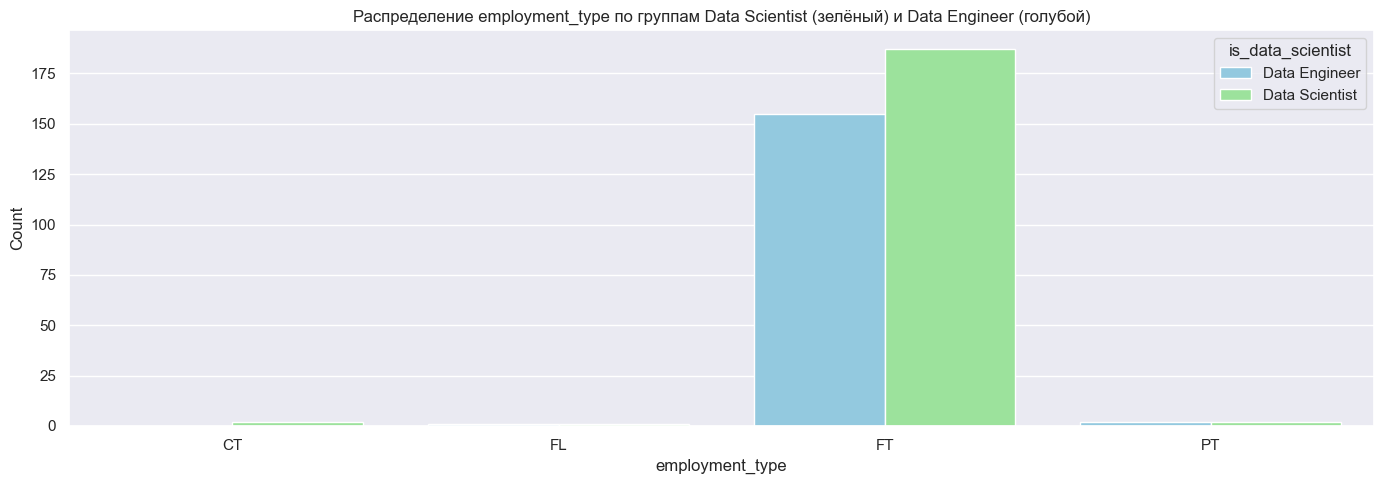

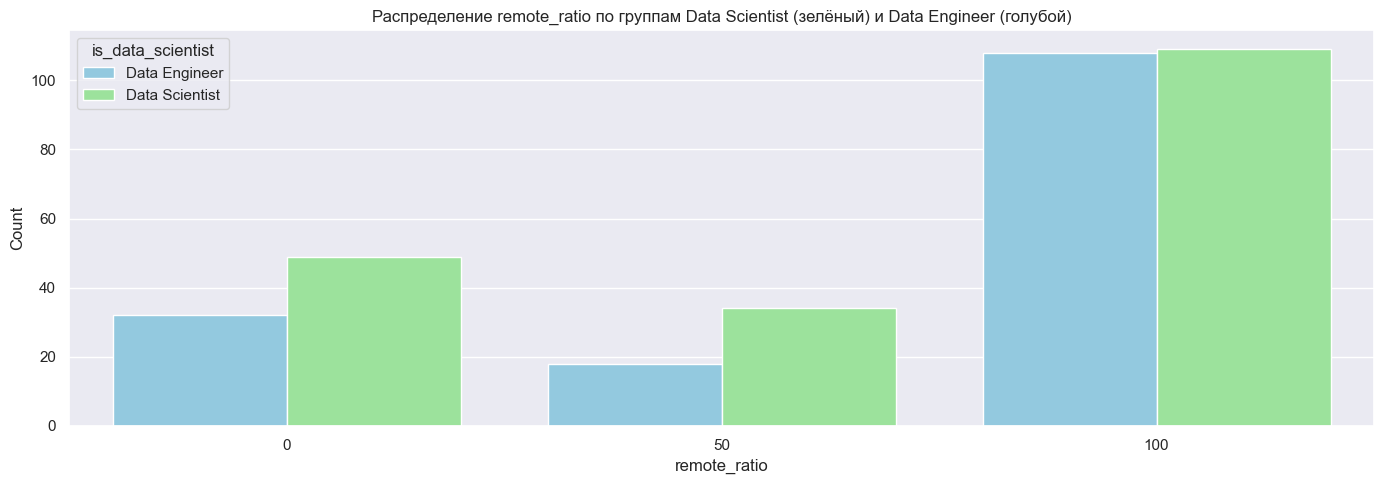

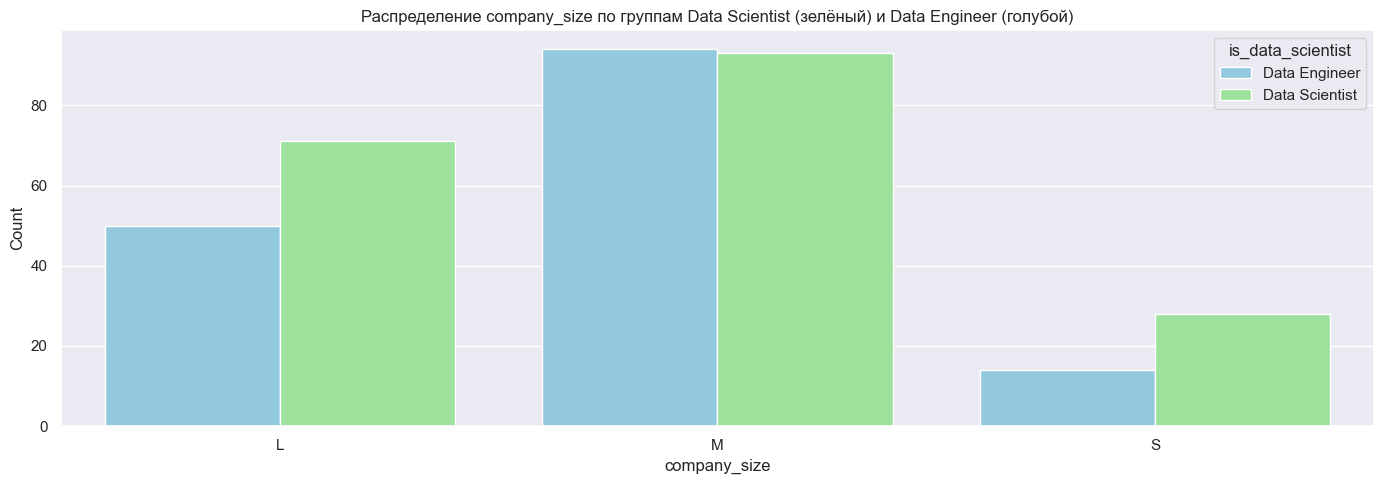

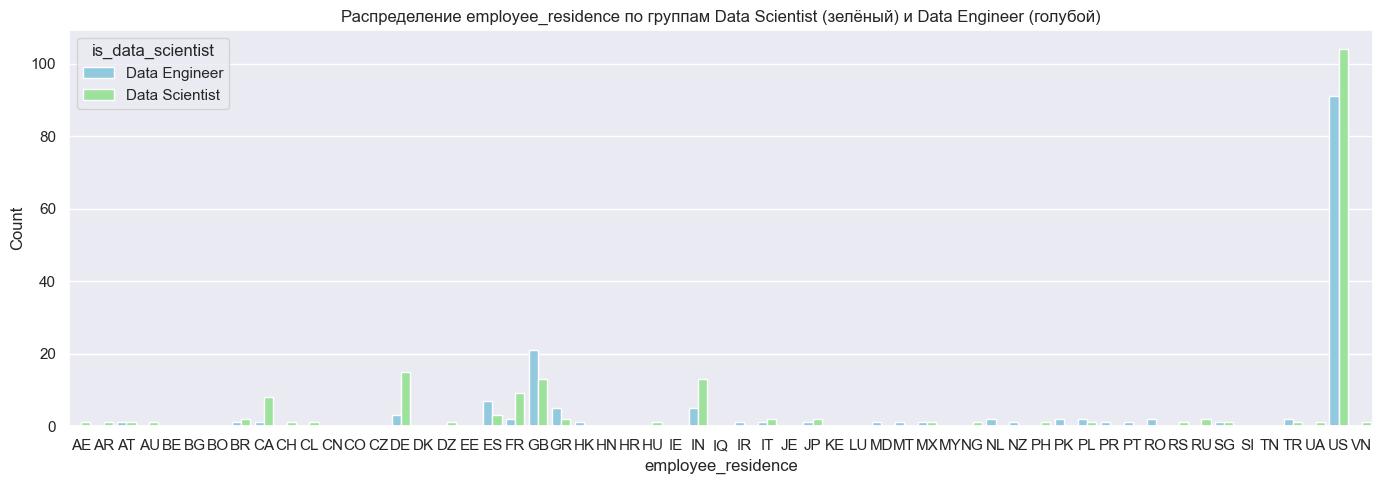

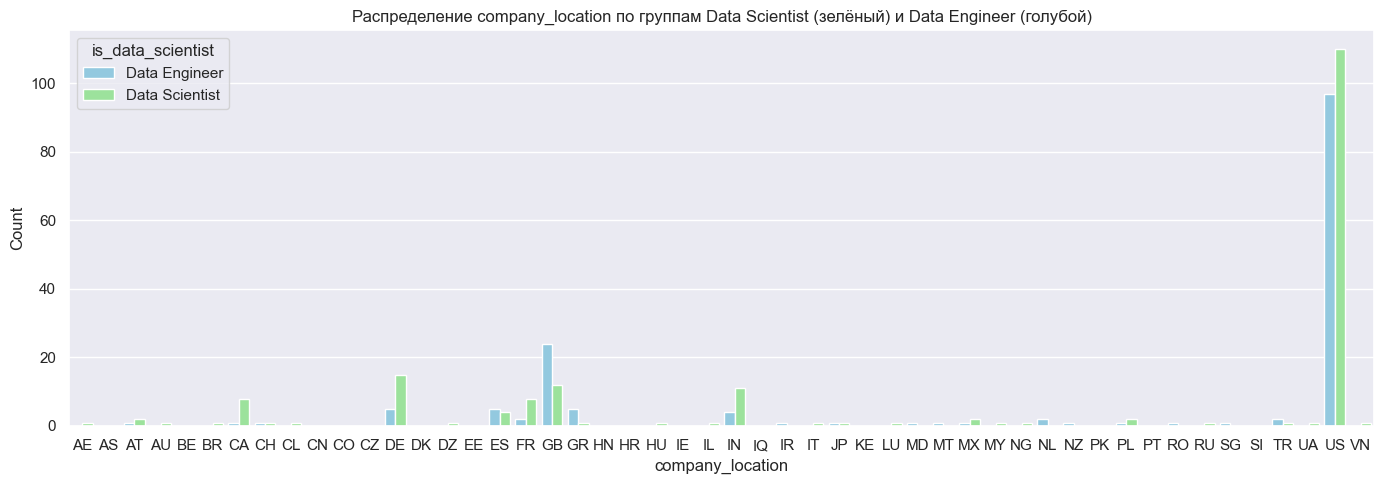

In [213]:
# Сравнительные barplot для категориальных признаков по группам Data Scientist и Data Engineer
categorical_cols = ['work_year', 'experience_level', 'employment_type', 'remote_ratio', 'company_size', 'employee_residence', 'company_location']
for col in categorical_cols:
    plt.figure(figsize=(14, 5))
    sns.countplot(data=data, x=col, hue='is_data_scientist', palette=['skyblue', 'lightgreen'])
    plt.title(f'Распределение {col} по группам Data Scientist (зелёный) и Data Engineer (голубой)')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.legend(title='is_data_scientist', labels=['Data Engineer', 'Data Scientist'])
    plt.tight_layout()
    plt.show()